In [4]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

In [5]:
pdbid='1L2Y'
pdbfile='trpcage_correct.pdb'
cvmodel='model_norm_500e_0002lr.pt'
mdbox=2.0
ntomp=4

In [6]:
gmx='gmx'

In [4]:
!{gmx} pdb2gmx -f {pdbfile} -o {pdbid}.gro -n {pdbid}.ndx -water tip3p -ff amber94 -p {pdbid}.top

grep: write error: Broken pipe
cat: write error: Broken pipe
              :-) GROMACS - gmx pdb2gmx, 2021-plumed-2.9.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       


In [ ]:
with open(f"{pdbid}.ndx") as f:
    f.readline()
    ndx = np.fromstring(" ".join(f),dtype=np.int32,sep=' ')-1

#ndx

In [ ]:
base = md.load(f'{pdbid}.gro')
nhs = base.topology.select('element != H')
base.save_pdb(f'{pdbid}-gmx.pdb')
#nhs

In [ ]:
orig2new = nhs[np.argsort(ndx)]+1
orig2new

In [ ]:
!{gmx} editconf -f {pdbid}.gro -o {pdbid}-box.gro -c -d {mdbox} -bt dodecahedron

In [ ]:
!{gmx} solvate -cp {pdbid}-box.gro -cs spc216.gro -o {pdbid}-solv.gro -p {pdbid}.top

In [ ]:
!{gmx} grompp -f ions.mdp -c {pdbid}-solv.gro -p {pdbid}.top -o ions.tpr

In [ ]:
!bash -c "echo 13 | {gmx} genion -s ions.tpr -o {pdbid}-ions.gro -p {pdbid}.top -pname NA -nname CL -neutral"

In [ ]:
!{gmx} grompp -f minim-sol.mdp -c {pdbid}-ions.gro -p {pdbid}.top -o em.tpr

In [ ]:
!{gmx} mdrun -v -deffnm em -ntomp {ntomp} -pin on

In [ ]:
!{gmx} grompp -f nvt.mdp -c em.gro -r em.gro -p {pdbid}.top -o nvt.tpr

In [ ]:
!{gmx} mdrun -ntomp {ntomp} -pin on -deffnm nvt

In [ ]:
!{gmx} grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p {pdbid}.top -o npt.tpr

In [ ]:
!{gmx} mdrun -ntomp {ntomp} -pin on -deffnm npt

In [ ]:
!bash -c "echo 18 | {gmx} energy -f npt.edr -o press.xvg" && \
bash -c "echo 24 | {gmx} energy -f npt.edr -o dens.xvg" && \
bash -c "echo 16 | {gmx} energy -f nvt.edr -o temp.xvg"

In [ ]:
temp = np.loadtxt('temp.xvg',comments=['#','@'])
press = np.loadtxt('press.xvg',comments=['#','@'])
dens = np.loadtxt('dens.xvg',comments=['#','@'])

In [ ]:
plt.figure(figsize=(15,9))
plt.subplot(311)
plt.plot(press[:,0],press[:,1])
plt.title('isothermal-isobaric equilibration')
plt.grid()
#plt.xlabel('time (ps)')
plt.ylabel("pressure (bar)")

plt.subplot(312)
plt.ylabel('density (kg/m3)')
plt.grid()
plt.plot(dens[:,0],dens[:,1])

plt.subplot(313)
plt.xlabel('time (ps)')
plt.ylabel('temperature (K)')
plt.grid()
plt.plot(temp[:,0],temp[:,1])

plt.show()

In [ ]:
with open("plumed.dat","w") as p:
    p.write(f"""
RESTART
WHOLEMOLECULES ENTITY0=1-{base.xyz.shape[1]}
model: PYTORCH_MODEL_CV FILE={cvmodel} ATOMS={','.join(map(str,orig2new))}
metad: METAD ARG=model.node-0,model.node-1 PACE=1000 HEIGHT=1 BIASFACTOR=15 SIGMA=0.1,0.1 GRID_MIN=-2,-2 GRID_MAX=2,2 FILE=HILLS
PRINT FILE=COLVAR ARG=model.node-0,model.node-1,metad.bias STRIDE=100
""")

In [ ]:
!cp md.mdp.template md.mdp

# 200 ns
mdsteps=100000000
with open('md.mdp','a') as mdp:
    mdp.write("nsteps = %d\n" % mdsteps)

!{gmx} grompp -f md.mdp -c npt.gro -t npt.cpt -p {pdbid}.top -o md.tpr 

In [ ]:
!bash -c "{gmx} mdrun -ntomp {ntomp} -pin on -deffnm md -plumed plumed.dat -cpi md.cpt -cpt 15 | egrep -v 'num out|compute graph'"

grep: write error: Broken pipe
cat: write error: Broken pipe
               :-) GROMACS - gmx mdrun, 2021-plumed-2.9.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
 

In [1]:
def pbc_and_fit(base):
    xtc = base + ".xtc"
    pbc = base + "-pbc.xtc"
    !bash -c "echo 1 | {gmx} trjconv -f {xtc} -s npt.gro -pbc nojump -o {pbc} 2>&1 | tail -100"
    tr = md.load_xtc(pbc,top=pdbid+'.gro')
    idx=tr[0].top.select("name CA")
    tr.superpose(tr[0],atom_indices=idx)
    return tr


In [11]:
tr1=pbc_and_fit('md')

grep: write error: Broken pipe
cat: write error: Broken pipe
              :-) GROMACS - gmx trjconv, 2021-plumed-2.9.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       


In [12]:
v = nv.show_mdtraj(tr1,gui=False)
v

NGLWidget(max_frame=40000)

In [13]:
def plot_colvar(stride=20):
    cv = np.transpose(np.loadtxt('COLVAR')[::stride])
    cv2 = cv[1:3]
    plt.figure(figsize=(12,12))
    plt.scatter(*cv2,c=range(cv2.shape[1]),marker='.',cmap=plt.get_cmap('rainbow'))
    plt.colorbar()
    plt.show()

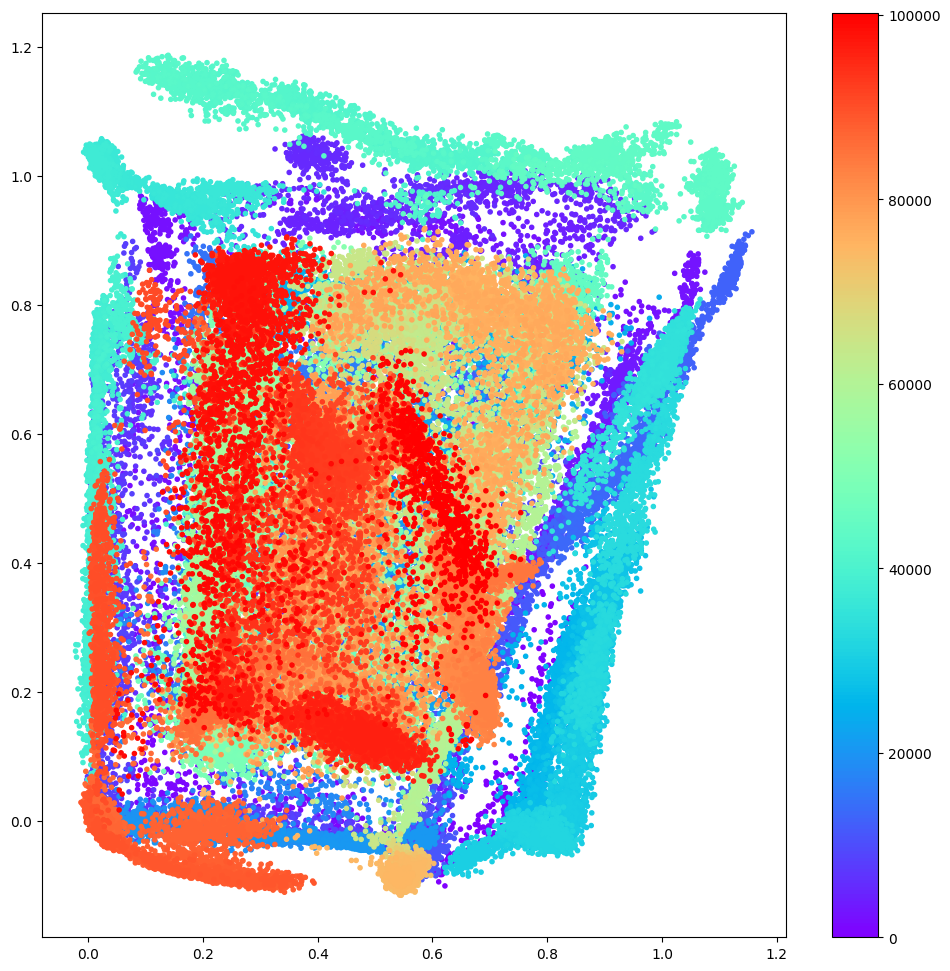

In [14]:
plot_colvar()